In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

def parse_detections(path, delimiter=None):
    with open(path, "r") as f:
        det_str_list = f.readlines()

    if len(det_str_list) == 0:
        return None

    conf_list = list()
    xyxy_list = list()

    for det_str in det_str_list:
        if delimiter is None:
            det_info = det_str.split()
        else:
            det_info = det_str.split(delimiter)

        conf = float(det_info[0])
        x1 = float(det_info[1])
        y1 = float(det_info[2])
        x2 = float(det_info[3])
        y2 = float(det_info[4])

        conf_list.append(torch.tensor(conf))
        xyxy_list.append(torch.tensor([x1, y1, x2, y2]).unsqueeze(0))

    return torch.tensor(conf_list).contiguous(), torch.cat(xyxy_list).contiguous()


In [3]:
from torch.utils.data import Dataset
import glob


class ReadDetAndGT(Dataset):
    def __init__(self, detection_path, ground_truth_path):
        self.detection_path = detection_path
        self.ground_truth_path = ground_truth_path
        self.ground_truth_files = sorted(glob.glob("%s/*.*" % self.ground_truth_path))
        self.detection_files = sorted(glob.glob("%s/*.*" % self.detection_path))

    def __getitem__(self, index):

        gt_path = self.ground_truth_files[index % len(self.ground_truth_files)]
        det_path = self.detection_files[index % len(self.detection_files)]

        gt_conf, gt_xyxy = parse_detections(gt_path)
        det_conf, det_xyxy = parse_detections(det_path)

        return gt_conf, gt_xyxy, det_conf, det_xyxy

    def __len__(self):
        return len(self.detection_files)


In [4]:
def iou(boxA, boxB):

    ax1 = boxA[..., 0]
    ay1 = boxA[..., 1]
    ax2 = boxA[..., 2]
    ay2 = boxA[..., 3]
    bx1 = boxB[..., 0]
    by1 = boxB[..., 1]
    bx2 = boxB[..., 2]
    by2 = boxB[..., 3]

    intersect = (torch.min(ax2, bx2) - torch.max(ax1, bx1)).clamp(0) * (
        torch.min(ay2, by2) - torch.max(ay1, by1)
    ).clamp(0)
    a_area = (ax2 - ax1) * (ay2 - ay1)
    b_area = (bx2 - bx1) * (by2 - by1)

    iou = intersect / (a_area + b_area - intersect + 1e-9)
    return iou

In [5]:
def classificate_tp_fp_fn(det_xyxy, gt_xyxy, iou_threshold=0.6):
    iou_matrix = iou(det_xyxy.unsqueeze(1), gt_xyxy.unsqueeze(0))
    tp_mask = (iou_matrix >= iou_threshold).any(dim=1)
    fp_mask = torch.logical_not(tp_mask)
    fn_mask = (iou_matrix < iou_threshold).all(dim=0)

    return tp_mask, fp_mask, fn_mask

In [6]:
def select_best_gt_tp(tp_xyxy, gt_xyxy):
    gt_rect_areas = (gt_xyxy[..., 2] - gt_xyxy[..., 0]) * (
        gt_xyxy[..., 3] - gt_xyxy[..., 1]
    )
    gt_max_rect_area_idx = gt_rect_areas.argmax()
    tp_idx = iou(
        tp_xyxy.unsqueeze(1), gt_xyxy[gt_max_rect_area_idx].unsqueeze(0).unsqueeze(0)
    ).argmax()
    return tp_idx, gt_max_rect_area_idx

In [7]:
from torch.utils.data import DataLoader
from tqdm import tqdm

detection_path = "../outputs/eval_background/2024-06-13_02-41-39/detections"
ground_truth_path = "../datasets/faceforensics_pp/train/detection"

dataloader = DataLoader(ReadDetAndGT(detection_path, ground_truth_path), batch_size=1)

columns = ["rect_area", "conf"]
tp_columns = columns + ["gt_rect_area", "gt_conf", "iou"]
tp_df = pd.DataFrame(index=[], columns=tp_columns)
gt_df = pd.DataFrame(index=[], columns=columns)
fp_df = pd.DataFrame(index=[], columns=columns)
fn_df = pd.DataFrame(index=[], columns=columns)

for gt_conf, gt_xyxy, det_conf, det_xyxy in tqdm(dataloader):
    gt_conf = gt_conf.squeeze(0)
    gt_xyxy = gt_xyxy.squeeze(0)
    det_conf = det_conf.squeeze(0)
    det_xyxy = det_xyxy.squeeze(0)

    gt_rect_area = (gt_xyxy[..., 2] - gt_xyxy[..., 0]) * (
        gt_xyxy[..., 3] - gt_xyxy[..., 1]
    )
    det_rect_area = (det_xyxy[..., 2] - det_xyxy[..., 0]) * (
        det_xyxy[..., 3] - det_xyxy[..., 1]
    )

    tp_mask, fp_mask, fn_mask = classificate_tp_fp_fn(det_xyxy, gt_xyxy)

    if gt_conf.nelement() != 0:
        for gt_i in range(len(gt_conf)):
            gt_df = pd.concat(
                [
                    gt_df,
                    pd.DataFrame(
                        {
                            "rect_area": gt_rect_area[gt_i].item(),
                            "conf": gt_conf[gt_i].item(),
                        },
                        index=[0],
                        columns=columns,
                    ),
                ]
            )

    if tp_mask.sum() > 0:
        tp_conf = det_conf[tp_mask]
        tp_rect_area = det_rect_area[tp_mask]
        tp_iou = iou(det_xyxy[tp_mask].unsqueeze(1), gt_xyxy.unsqueeze(0))
        gt_matching_idx = tp_iou.argmax(dim=1)

        for tp_i in range(len(tp_conf)):
            tp_df = pd.concat(
                [
                    tp_df,
                    pd.DataFrame(
                        {
                            "rect_area": tp_rect_area[tp_i].item(),
                            "conf": tp_conf[tp_i].item(),
                            "gt_conf": gt_conf[gt_matching_idx[tp_i]].item(),
                            "gt_rect_area": gt_rect_area[gt_matching_idx[tp_i]].item(),
                            "iou": tp_iou[tp_i, gt_matching_idx[tp_i]].item(),
                        },
                        index=[0],
                        columns=tp_columns,
                    ),
                ]
            )
        # 一つだけ選定する場合
        # best_tp_idx, best_gt_idx = select_best_gt_tp(det_xyxy[tp_mask], gt_xyxy)
        # tp_conf = det_conf[best_tp_idx]
        # tp_rect_area = det_rect_area[best_tp_idx]

        # tp_df = pd.concat(
        #     [
        #         tp_df,
        #         pd.DataFrame(
        #             {
        #                 "rect_area": tp_rect_area.item(),
        #                 "conf": tp_conf.item(),
        #                 "gt_conf": gt_conf[best_gt_idx].item(),
        #                 "gt_rect_area": gt_rect_area[best_gt_idx].item(),
        #                 "iou": iou(det_xyxy[best_tp_idx], gt_xyxy[best_gt_idx]).item(),
        #             },
        #             index=[0],
        #             columns=tp_columns,
        #         ),
        #     ]
        # )

    if fp_mask.sum() > 0:
        fp_conf = det_conf[fp_mask]
        fp_rect_area = det_rect_area[fp_mask]

        for fp_i in range(len(fp_conf)):
            fp_df = pd.concat(
                [
                    fp_df,
                    pd.DataFrame(
                        {
                            "rect_area": fp_rect_area[fp_i].item(),
                            "conf": fp_conf[fp_i].item(),
                        },
                        index=[0],
                        columns=columns,
                    ),
                ]
            )
    if fn_mask.sum() > 0:
        fn_conf = gt_conf[fn_mask]
        fn_rect_area = gt_rect_area[fn_mask]

        for fn_i in range(len(fn_conf)):
            fn_df = pd.concat(
                [
                    fn_df,
                    pd.DataFrame(
                        {
                            "rect_area": fn_rect_area[fn_i].item(),
                            "conf": gt_conf[fn_i].item(),
                        },
                        index=[0],
                        columns=columns,
                    ),
                ]
            )

tp_df["conf_diff"] = tp_df["gt_conf"] - tp_df["conf"]

tp_df.to_csv("tp_df.csv", index=True)
gt_df.to_csv("gt_df.csv", index=True)
fp_df.to_csv("fp_df.csv", index=True)
fn_df.to_csv("fn_df.csv", index=True)


  0%|          | 0/3000 [00:00<?, ?it/s]/tmp/ipykernel_498959/74233041.py:33: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  gt_df = pd.concat(
/tmp/ipykernel_498959/74233041.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gt_df = pd.concat(
/tmp/ipykernel_498959/74233041.py:54: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the 

In [8]:
tp_df = pd.read_csv("tp_df.csv")
gt_df = pd.read_csv("gt_df.csv")
fp_df = pd.read_csv("fp_df.csv")
fn_df = pd.read_csv("fn_df.csv")

In [9]:

# 0から1までを100等分する区間を作成
bins = np.linspace(0, 1, 101)
ylabel = "Count"

def calc_per_bin_statistics(df, bins, col_name):
    # 各値を100等分のビンに割り当てる
    df['bin'] = pd.cut(df[col_name], bins=bins, include_lowest=True)

    # 各ビンごとに統計量を計算
    statistics = df.groupby('bin', observed=False)[col_name].agg(['count', 'mean', 'median', 'std', 'min', 'max']).reset_index()

    return statistics

def plt_bar(ax, statistics, title, xlabel, ylabel):
    # plt.figure(figsize=(12, 6))
    # plt.bar(range(len(statistics)), statistics['count'], width=1, edgecolor='black')
    # plt.xlabel(xlabel)
    # plt.ylabel(ylabel)
    # plt.title(title)
    # plt.xticks(range(len(statistics)), statistics['bin'], rotation=90)
    # plt.show()
    ax.bar(range(len(statistics)), statistics['count'], width=1, edgecolor='black')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    xticklabel = [ statistics['bin'][i] if (i%10==0) else "" for i in range(len(statistics))]
    ax.set_xticks(range(len(statistics)))
    ax.set_xticklabels(xticklabel, rotation=90)

## TP・FP・FNの顔面積の分布

In [10]:
xlabel1="rectangular areas"
min_rect_area = min([tp_df["rect_area"].min(), gt_df["rect_area"].min(), fp_df["rect_area"].min(), fn_df["rect_area"].min()])
max_rect_area = max([tp_df["rect_area"].max(), gt_df["rect_area"].max(), fp_df["rect_area"].max(), fn_df["rect_area"].max()])
# bins1 = np.linspace(min_rect_area, max_rect_area, 101)
bins1 = np.load("./facepp_test/bins1.npy")

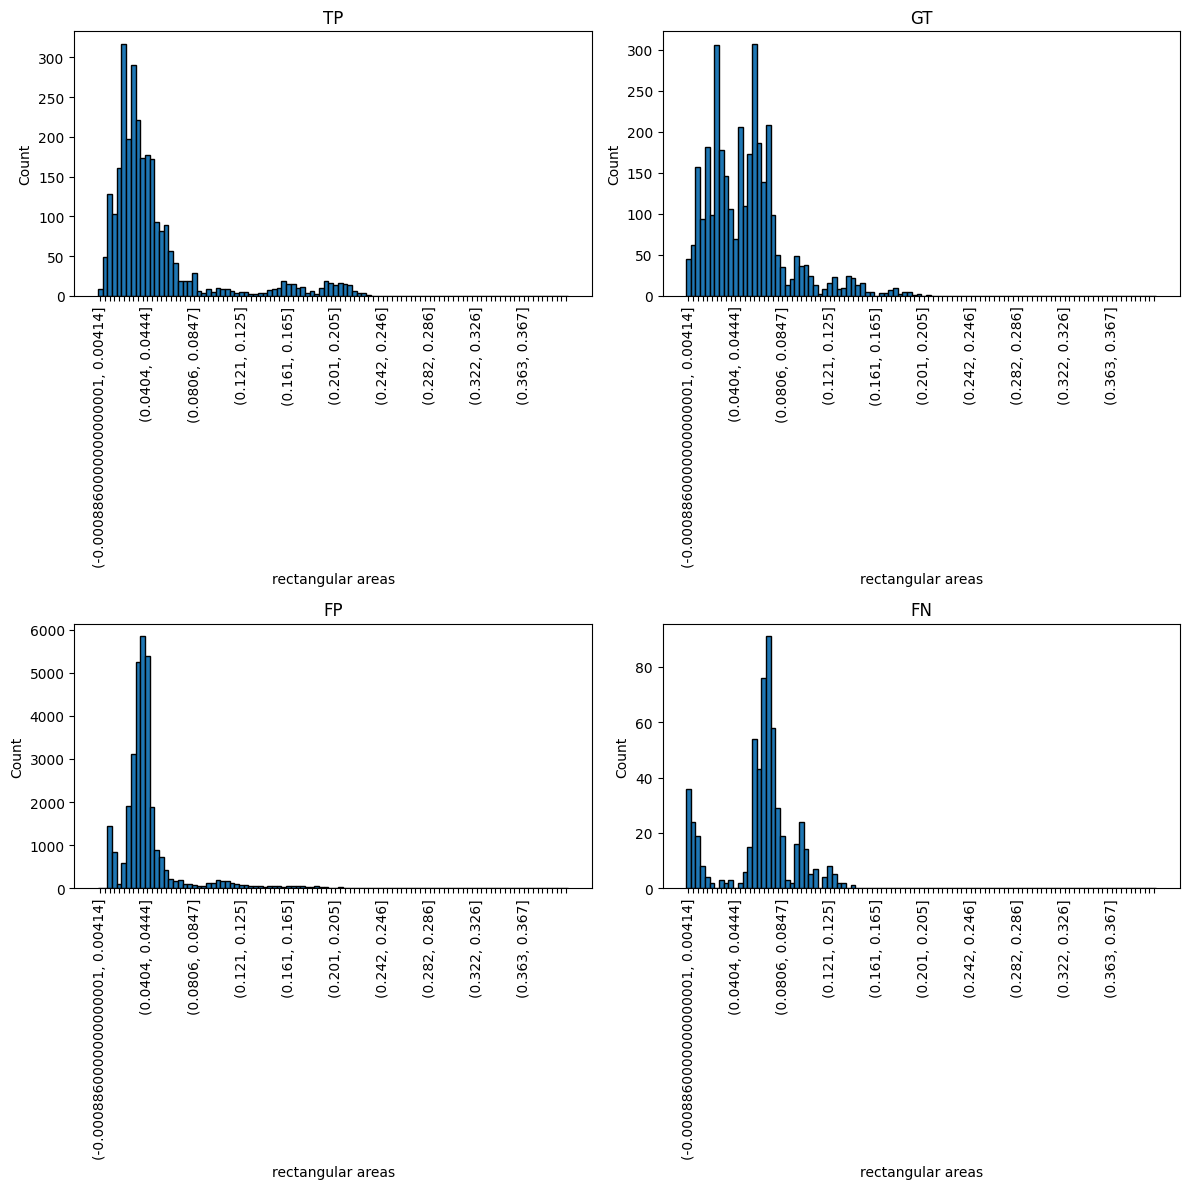

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

ax = axes[0,0]
tp_statistics = calc_per_bin_statistics(tp_df, bins1, 'rect_area')
plt_bar(ax, tp_statistics, "TP", xlabel1, ylabel)

ax = axes[0,1]
# tp_gt_statistics = calc_per_bin_statistics(tp_df, bins1, 'gt_rect_area')
# plt_bar(ax, tp_gt_statistics, "Distribution of rectangular areas in GT detection.", xlabel1, ylabel)
gt_stastics = calc_per_bin_statistics(gt_df, bins1, 'rect_area')
plt_bar(ax, gt_stastics, "GT", xlabel1, ylabel)

ax = axes[1,0]
fp_statistics = calc_per_bin_statistics(fp_df, bins1, 'rect_area')
plt_bar(ax, fp_statistics, "FP", xlabel1, ylabel)

ax = axes[1,1]
fn_statistics = calc_per_bin_statistics(fn_df, bins1, 'rect_area')
plt_bar(ax, fn_statistics, "FN", xlabel1, ylabel)

plt.tight_layout()
plt.show()

## iouの検証

TPのGTとのIoUの分布を見ることで妨害によりどの程度検出の座標や形状が変動しているかを検証する

In [12]:
xlabel2="iou"
bins2 = np.linspace(tp_df["iou"].min(), tp_df["iou"].max(), 101)

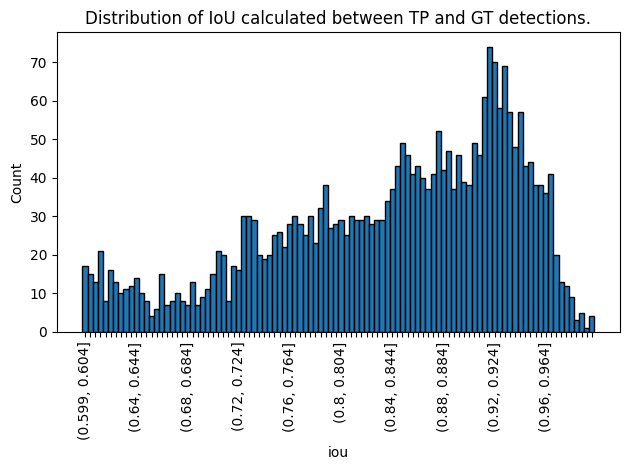

In [13]:
fig, ax = plt.subplots()
iou_statistics = calc_per_bin_statistics(tp_df, bins2, 'iou')
plt_bar(ax, iou_statistics,"Distribution of IoU calculated between TP and GT detections.", xlabel2, ylabel)
plt.tight_layout()
plt.show()

## 信頼値の検証

元々の信頼値と現在の信頼値の差分を取り、その分布を見ることで妨害によりどの程度信頼値が減少しているかを検証する

In [14]:
xlabel3="conf_diff"
bins3 = np.linspace(tp_df["conf_diff"].min(), tp_df["conf_diff"].max(), 101)

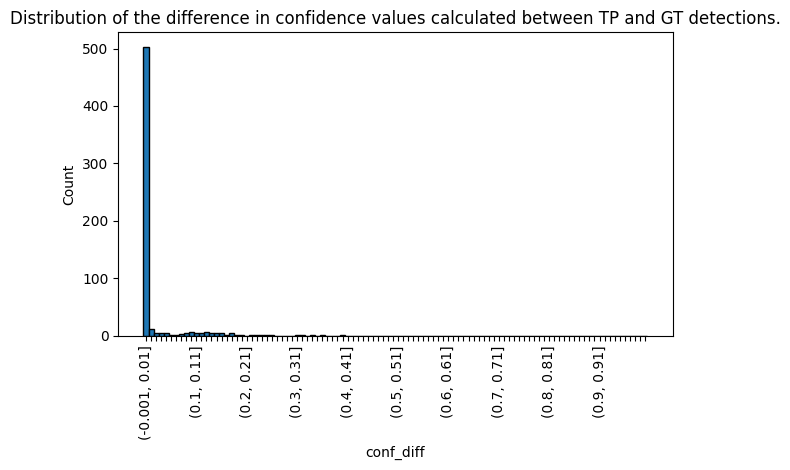

In [15]:
fig, ax = plt.subplots()
conf_diff_statistics = calc_per_bin_statistics(tp_df, bins, 'conf_diff')
plt_bar(ax, conf_diff_statistics, "Distribution of the difference in confidence values calculated between TP and GT detections.",xlabel3, ylabel)
plt.tight_layout()
plt.show()

In [16]:
len(tp_df)

2746

In [17]:
len(gt_df)

3333

In [18]:
len(fn_df)

587

In [19]:
len(fp_df)

31465

In [20]:
# np.save("bins1.npy",bins1)